In [1]:
import numpy as np

import pydot
from IPython.display import display, SVG

from matplotlib import pyplot as plt

from RobotDiagram import RobotDiagram
from AbbMotionPlanner import AbbMotionPlanner
from GripperMotionController import GripperMotionController
from ProcessPointCloud import ProcessPointCloud

from pydrake.all import (
    DiagramBuilder,
    StartMeshcat,   
    Simulator,
    Diagram,
    VectorLogSink,
    RigidTransform,
    RotationMatrix,
    ConstantVectorSource,
    VectorLogSink,
    Context,
    AbstractValue,
    Rgba,
    Box,
    MeshcatPointCloudVisualizer,
    BaseField
)

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
def get_diagram(X_WG:RigidTransform) -> tuple[Diagram, Context]:
    builder = DiagramBuilder()
    system = builder.AddNamedSystem("plant_subsystem", RobotDiagram(0.001, meshcat=meshcat, models_to_add=["world/world.sdf"], pc_fields=BaseField.kXYZs))

    svh_desired_state = system.GetInputPort("svh_desired_state")
    irb_desired_state = system.GetInputPort("irb1200_desired_state")

    abb_motion_planner = builder.AddSystem(AbbMotionPlanner(5))
    builder.Connect(abb_motion_planner.get_output_port(), irb_desired_state)

    desired_sink:VectorLogSink = builder.AddNamedSystem("desired_sink", VectorLogSink(abb_motion_planner.get_output_port().size()))
    builder.Connect(abb_motion_planner.get_output_port(), desired_sink.get_input_port())

    svh_source = builder.AddSystem(ConstantVectorSource(np.zeros(svh_desired_state.size())))

    builder.Connect(svh_source.get_output_port(), svh_desired_state)

    svh_state = system.GetOutputPort("svh_state")
    irb_state = system.GetOutputPort("irb1200_state")

    builder.Connect(irb_state, abb_motion_planner.GetInputPort("irb1200_estimated_state"))
    svh_sink:VectorLogSink = builder.AddNamedSystem("svh_sink", VectorLogSink(svh_state.size()))
    irb_sink:VectorLogSink = builder.AddNamedSystem("irb_sink", VectorLogSink(irb_state.size()))

    builder.Connect(svh_state, svh_sink.get_input_port())
    builder.Connect(irb_state, irb_sink.get_input_port())
    builder.ExportOutput(system.GetOutputPort("camera0_color_image"), "camera0_color_image")
    builder.ExportOutput(system.GetOutputPort("camera0_depth_image"), "camera0_depth_image")

    builder.ExportOutput(system.GetOutputPort("camera1_color_image"), "camera1_color_image")
    builder.ExportOutput(system.GetOutputPort("camera1_depth_image"), "camera1_depth_image")
    
    concat = builder.AddSystem(ProcessPointCloud())
    builder.Connect(system.GetOutputPort("point_cloud_0"), concat.get_input_port(0))
    builder.Connect(system.GetOutputPort("point_cloud_1"), concat.get_input_port(1))
    pc_vis = builder.AddSystem(MeshcatPointCloudVisualizer(meshcat, "/drake", 1.0))
    builder.Connect(concat.get_output_port(), pc_vis.cloud_input_port())

    diagram:Diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    abb_motion_planner.GetInputPort("target_ee_location").FixValue(abb_motion_planner.GetMyContextFromRoot(context), AbstractValue.Make(X_WG))
    return diagram, context


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


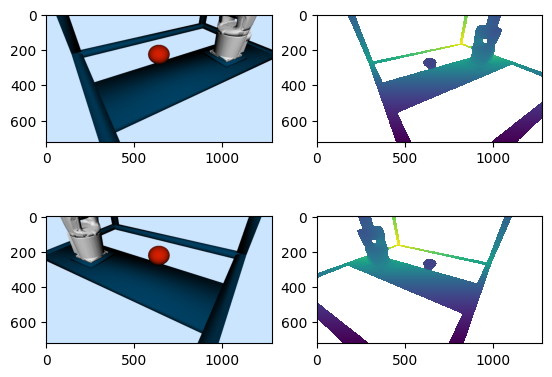

In [4]:

def show_mock_triad(name:str, pose:RigidTransform):
    # Create a triad like object that shows the goal orientation
    meshcat.SetObject(name+"_x", Box(0.02, 0.02, 0.06), rgba=Rgba(0.9, 0.1, 0.1, 1))
    meshcat.SetTransform(name+"_x", pose @ RigidTransform(RotationMatrix().MakeYRotation(-np.pi/2), [0.03, 0, 0]))

    meshcat.SetObject(name+"_y", Box(0.02, 0.02, 0.06), rgba=Rgba(0.1, 0.9, 0.1, 1))
    meshcat.SetTransform(name+"_y", pose @ RigidTransform(RotationMatrix().MakeXRotation(np.pi/2), [0, 0.03, 0]))

    meshcat.SetObject(name+"_z", Box(0.02, 0.02, 0.06), rgba=Rgba(0.1, 0.1, 0.9, 1))
    meshcat.SetTransform(name+"_z", pose @ RigidTransform(RotationMatrix(), [0, 0, 0.03]))

meshcat.Delete()
meshcat.DeleteRecording()
meshcat.DeleteAddedControls()

X_WG = RigidTransform(RotationMatrix().MakeXRotation(np.pi) @ RotationMatrix().MakeYRotation(np.pi/2), [0.5, 0.0, 0.3])

# Simulation
diagram, context = get_diagram(X_WG)
sim = Simulator(diagram, context)
sim.Initialize()
color_image_0 = diagram.GetOutputPort("camera0_color_image").Eval(context)
depth_image_0 = diagram.GetOutputPort("camera0_depth_image").Eval(context)
color_image_1 = diagram.GetOutputPort("camera1_color_image").Eval(context)
depth_image_1 = diagram.GetOutputPort("camera1_depth_image").Eval(context)

fig, axs = plt.subplots(2,2)
axs[0, 0].imshow(color_image_0.data)
axs[0, 1].imshow(depth_image_0.data)
axs[1, 0].imshow(color_image_1.data)
axs[1, 1].imshow(depth_image_1.data)

meshcat.StartRecording()
sim.AdvanceTo(10.0)
meshcat.PublishRecording()

X_WC0 = diagram.GetSubsystemByName("plant_subsystem").camera_pose_0
show_mock_triad("camera0", X_WC0)

X_WC1 = diagram.GetSubsystemByName("plant_subsystem").camera_pose_1
show_mock_triad("camera1", X_WC1)